#  Sentiment Analysis of IMDB Movie Reviews

#### Katerina Tsilingiri (2806) & Noli Chrysa (2780) & Panos Petropoulos (2610) [TeamK]

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
from sklearn.model_selection import train_test_split
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

2022-06-05 13:14:00.581867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-05 13:14:00.581889: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### (1) load & explore dataset

In [2]:
#importing the training data
df=pd.read_csv("IMDB_Dataset.csv")
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [14]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [15]:
df['sentiment'].value_counts()  # balanced data (!)

positive    25000
negative    25000
Name: sentiment, dtype: int64

### (2) data pre-process

#### remove text noise 

In [7]:
#removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

df['review']=df['review'].apply(strip_html)
df['review']=df['review'].apply(remove_between_square_brackets)

#### remove special characters

In [8]:
#define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

df['review']=df['review'].apply(remove_special_characters)


#### text stemming  (takes long time)

In [9]:
#define function for stemming the text with ntlk
def text_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

df['review']=df['review'].apply(text_stemmer)


#### stopwords removal

In [22]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [23]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

df['review']=df['review'].apply(remove_stopwords)


{'between', 'has', 'my', 'our', 'because', 'at', 'some', "it's", 'is', "wasn't", "hasn't", 'whom', "don't", 'me', 'being', 's', 'shouldn', 'does', 'its', 'here', 'isn', 'her', 'where', 'should', "isn't", 'o', "she's", 'of', 'why', "needn't", 'you', "you've", "should've", 'during', 'yours', 'himself', 'needn', 'once', 'than', 'but', 'such', 'above', 'into', 'have', 'from', 'then', 'when', "haven't", 'on', 'each', 're', 'so', 'were', 'very', 'most', 'about', 'how', 'that', "won't", 'mustn', 'will', 'y', 'm', 'was', "didn't", 'll', 'had', 'against', 'yourself', 'your', 'hadn', 'be', 'until', "you'll", 'now', 'after', 'what', 'below', 'couldn', "mustn't", 'their', "you're", 'with', 'all', 'which', 'did', 'this', 'him', 'herself', 'won', 'those', 'themselves', 'other', 'shan', 'can', 'are', 'and', 'ours', 'no', 'i', 'these', 'a', 'she', 'for', 'off', 'out', "aren't", 'wouldn', 'wasn', 'ma', 'hers', 'to', 'as', 'over', 't', 'ain', "doesn't", "couldn't", 'itself', 'same', 'am', 'both', "that'

#### text tokenization

In [24]:

df['review_tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['review']), axis=1)
df['review_tokenized'] = df['review_tokenized'].apply(lambda x: ' '.join([word for word in x]))


#### text vectorization

In [25]:
#Tfidf vectorizer
TfidfVec=TfidfVectorizer()
X_normalized=TfidfVec.fit_transform(df['review_tokenized'])


#### label sentiment data

In [26]:
#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data with 0 (engative) or 1 (positive) for label
Y_normalized=lb.fit_transform(df['sentiment'])

### (3) some data visualization..

<function matplotlib.pyplot.show(close=None, block=None)>

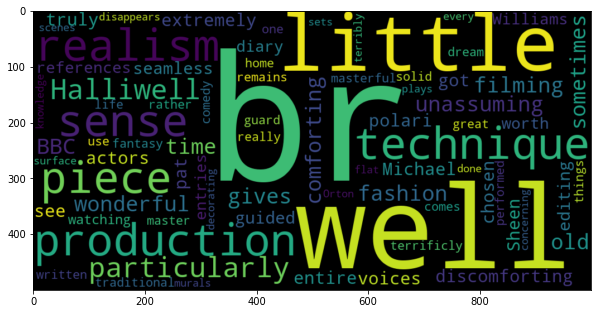

In [27]:

#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=df['review_tokenized'][1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

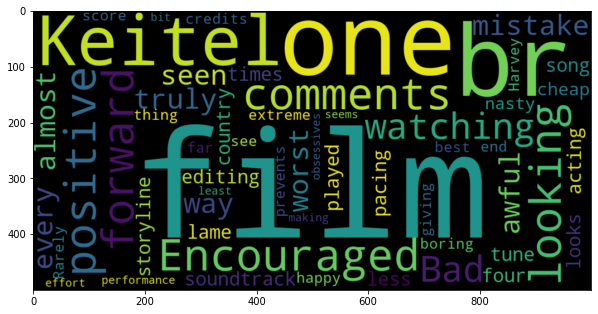

In [28]:

#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=df['review_tokenized'][8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show



### (4) split dataset

In [29]:
# 40000 reviews for training and 10000 for testing
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y_normalized, train_size=0.8, random_state=42)

### (5) modelling the dataset

#### Logistic Regression

/Users/katerinatsilingiri/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LOGISTIC REGRESSION ACCURACY SCORE:  0.8979


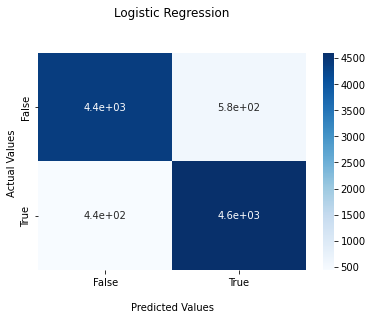

In [30]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1)
fitted_lr=lr.fit(X_train,Y_train)
Y_predicted=fitted_lr.predict(X_test)

lr_accuracy_score=accuracy_score(Y_test,Y_predicted)
print("LOGISTIC REGRESSION ACCURACY SCORE: ",lr_accuracy_score)

cm=confusion_matrix(Y_test,Y_predicted,labels=[0,1])
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Logistic Regression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Multinomial Naive Bayes

/Users/katerinatsilingiri/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NAIVE BAYES ACCURACY SCORE:  0.8672


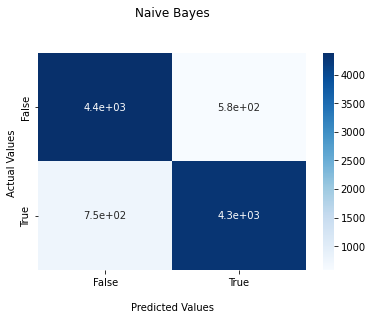

In [31]:
mnb=MultinomialNB()
fitted_mnb=mnb.fit(X_train,Y_train)
Y_predicted = fitted_mnb.predict(X_test)

mnb_accuracy_score=accuracy_score(Y_test,Y_predicted)
print("NAIVE BAYES ACCURACY SCORE: ",mnb_accuracy_score)

cm=confusion_matrix(Y_test,Y_predicted,labels=[0,1])
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Naive Bayes\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Random Forest

/var/folders/t6/2smmn5l964q6s88ytd8w9bt40000gn/T/ipykernel_3961/2662159946.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fitted_rf=rf.fit(X_train,Y_train)


RANDOM FOREST ACCURACY SCORE:  0.8281


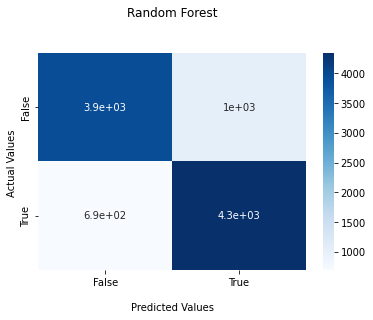

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 10, random_state=0)
fitted_rf=rf.fit(X_train,Y_train)
Y_predicted = fitted_rf.predict(X_test)

rf_accuracy_score=accuracy_score(Y_test,Y_predicted)
print("RANDOM FOREST ACCURACY SCORE: ",rf_accuracy_score)

cm=confusion_matrix(Y_test,Y_predicted,labels=[0,1])
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Adamboost

/Users/katerinatsilingiri/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ADABOOST ACCURACY SCORE:  0.7309


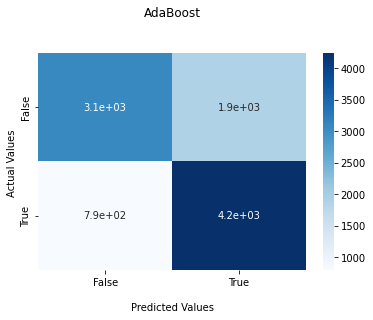

In [33]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(n_estimators=10, random_state=0)
fitted_adb=adb.fit(X_train,Y_train)
Y_predicted = fitted_adb.predict(X_test)

adb_accuracy_score=accuracy_score(Y_test,Y_predicted)
print("ADABOOST ACCURACY SCORE: ",adb_accuracy_score)

cm=confusion_matrix(Y_test,Y_predicted,labels=[0,1])
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('AdaBoost\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### SVM

/Users/katerinatsilingiri/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM ACCURACY SCORE:  0.8956


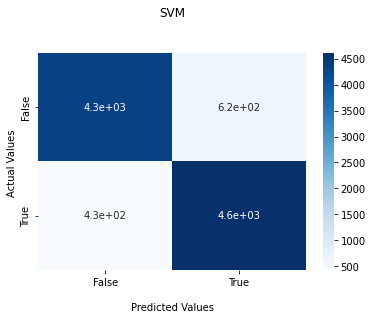

In [34]:
svm=SGDClassifier(loss='hinge',max_iter=500)
fitted_svm=svm.fit(X_train,Y_train)
Y_predicted=fitted_svm.predict(X_test)

svm_accuracy_score=accuracy_score(Y_test,Y_predicted)
print("SVM ACCURACY SCORE: ",svm_accuracy_score)

cm=confusion_matrix(Y_test,Y_predicted,labels=[0,1])
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('SVM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Deep Learning

In [145]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dropout, MaxPooling1D

In [42]:
model = Sequential()
model.add(Dense(12, input_dim=101887, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
model.fit(X_train, Y_train,
          epochs=10, batch_size = 10)

Epoch 1/10
4000/4000 [==============================] - 57s 14ms/step - loss: 0.0028 - accuracy: 0.9991
Epoch 2/10
4000/4000 [==============================] - 57s 14ms/step - loss: 8.4579e-04 - accuracy: 0.9998
Epoch 3/10
4000/4000 [==============================] - 57s 14ms/step - loss: 3.6601e-04 - accuracy: 0.9999
Epoch 4/10
4000/4000 [==============================] - 58s 14ms/step - loss: 1.6979e-04 - accuracy: 1.0000
Epoch 5/10
4000/4000 [==============================] - 58s 14ms/step - loss: 1.2782e-04 - accuracy: 1.0000
Epoch 6/10
4000/4000 [==============================] - 58s 14ms/step - loss: 9.4918e-05 - accuracy: 1.0000
Epoch 7/10
4000/4000 [==============================] - 58s 15ms/step - loss: 9.2090e-05 - accuracy: 1.0000
Epoch 8/10
4000/4000 [==============================] - 59s 15ms/step - loss: 8.2848e-05 - accuracy: 1.0000
Epoch 9/10
4000/4000 [==============================] - 58s 15ms/step - loss: 6.2177e-05 - accuracy: 1.0000
Epoch 10/10
4000/4000 [=========

In [47]:
accuracy = model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5221 - accuracy: 0.8741
